In [9]:
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import gzip
import json
import random
import numpy as np

In [10]:
def load_data(mode='train',batch_size = 100):
    datafile = './mnist .json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    # 加载json数据文件
    data = json.load(gzip.open(datafile))
    print('mnist dataset load done')
   
    # 读取到的数据区分训练集，验证集，测试集
    train_set, val_set, eval_set = data
    if mode=='train':
        # 获得训练数据集
        imgs, labels = train_set[0], train_set[1]
    elif mode=='valid':
        # 获得验证数据集
        imgs, labels = val_set[0], val_set[1]
    elif mode=='eval':
        # 获得测试数据集
        imgs, labels = eval_set[0], eval_set[1]
    else:
        raise Exception("mode can only be one of ['train', 'valid', 'eval']")
    print("训练数据集数量: ", len(imgs))
    
    # 校验数据
    imgs_length = len(imgs)

    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))
    
    # 获得数据集长度
    imgs_length = len(imgs)
    
    # 定义数据集每个数据的序号，根据序号读取数据
    index_list = list(range(imgs_length))
    # 读入数据时用到的批次大小
    BATCHSIZE = batch_size
    
    # 定义数据生成器
    def data_generator():
        if mode == 'train':
            # 训练模式下打乱数据
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            # 将数据处理成希望的类型
            img = np.array(imgs[i]).astype('float32')
            label = np.array(labels[i]).astype('float32')
            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                # 获得一个batchsize的数据，并返回
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据读取列表
                imgs_list = []
                labels_list = []
    
        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)
    return data_generator

In [19]:
import numpy as np

class TwoLayerNetwork(object):
    def __init__(self, num_of_inputs, num_of_hidden, num_of_outputs):
        self.W1 = np.random.randn(num_of_inputs, 100)
        self.b1 = np.zeros((1, 100))
        self.W2 = np.random.randn(100, 10)
        self.b2 = np.zeros((1, 10))
        self.W3 = np.random.randn(10,num_of_outputs)
        self.b3 = np.zeros((1,1))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2,self.W3) + self.b3
        return self.z3

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def loss(self, y_pred, y_true):
        error = y_pred - y_true
        num_samples = y_pred.shape[0]
        cost = np.sum(error ** 2) / num_samples
        return cost

    def gradient(self, X, y_pred, y_true):
        m = y_pred.shape[0]
        delta3 = (y_pred - y_true) 
        # print(f"ypred{y_pred.shape}, y_true{y_true.shape},delta3{delta3.shape}")
        dW3 = np.dot(self.a2.T, delta3) / m
        db3 = np.sum(delta3, axis=0) / m
        delta2 = np.dot(delta3, self.W3.T) * self.sigmoid_derivative(self.z2)
        dW2 = np.dot(self.a1.T, delta2) / m
        db2 = np.sum(delta2, axis=0) / m
        delta1 = np.dot(delta2, self.W2.T) * self.sigmoid_derivative(self.z1)
        dW1 = np.dot(X.T, delta1) / m
        db1 = np.sum(delta1, axis=0) / m
        return dW1, db1, dW2, db2, dW3, db3

    def update(self, dW1, db1, dW2, db2, dW3, db3,eta):
        self.W1 -= eta * dW1
        self.b1 -= eta * db1
        self.W2 -= eta * dW2
        self.b2 -= eta * db2
        self.W3 -= eta * dW3
        self.b3 -= eta * db3

    def train(self, num_epochs, batch_size=10, eta=0.01):
        losses = []
        train_loader = load_data('train',batch_size=batch_size)
        for epoch_id in range(num_epochs):
            for batch_id, data in enumerate(train_loader()):
                images, labels = data
                labels=labels.reshape(batch_size,1)
                # 前向
                predicts = self.forward(images)

                # 损失
                cost = self.loss(predicts, labels)

                # 每隔200记录一下

                # 每训练200，记录一下
                if batch_id % 200 == 0:
                    print("epoch: {}, batch: {}, loss is: {}".format(
                         epoch_id, batch_id, cost))
                
                # 反向梯度传播
                w1, b1, w2, b2, w3, b3 = self.gradient(images,predicts,labels)
                self.update(w1,b1,w2,b2,w3,b3,eta)
            losses.append(cost)
        
        return losses
    
    def predict(self, X):
        z1 = np.dot(X, self.W1) + self.b1
        a1 = self.sigmoid(z1)
        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.sigmoid(z2)
        z3 = np.dot(a2, self.W3) + self.b3
        return z3



 

loading mnist dataset from ./mnist .json.gz ......
mnist dataset load done
训练数据集数量:  50000
epoch: 0, batch: 0, loss is: 12.16003911075606
epoch: 0, batch: 200, loss is: 9.578388625669808
epoch: 0, batch: 400, loss is: 4.744920764723926
epoch: 0, batch: 600, loss is: 6.760684232561042
epoch: 0, batch: 800, loss is: 5.771664733857268
epoch: 0, batch: 1000, loss is: 7.644541832629228
epoch: 0, batch: 1200, loss is: 5.621135632975802
epoch: 0, batch: 1400, loss is: 3.140610744659857
epoch: 0, batch: 1600, loss is: 4.372564556390474
epoch: 0, batch: 1800, loss is: 5.267655094493301
epoch: 0, batch: 2000, loss is: 3.878714936570635
epoch: 0, batch: 2200, loss is: 3.3652919162713646
epoch: 0, batch: 2400, loss is: 2.2670630446101496
epoch: 1, batch: 0, loss is: 3.935144335250162
epoch: 1, batch: 200, loss is: 3.2041542265960126
epoch: 1, batch: 400, loss is: 3.8802104277049496
epoch: 1, batch: 600, loss is: 3.217574050870559
epoch: 1, batch: 800, loss is: 2.0084915408739477
epoch: 1, batch: 1

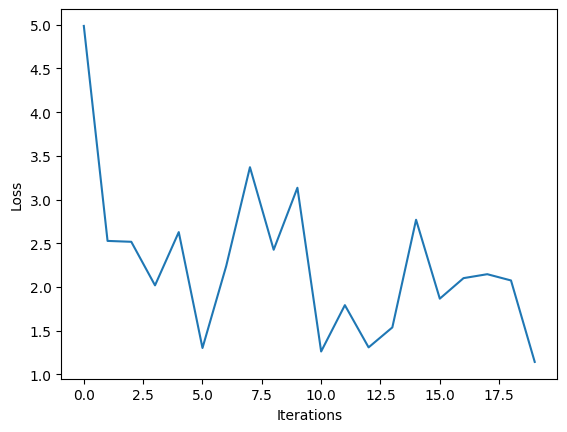

In [20]:


# 创建网络
net = TwoLayerNetwork(num_of_inputs=784, num_of_hidden=784, num_of_outputs=1)

# 启动训练
losses = net.train( num_epochs=20, batch_size=20, eta=0.01)

# 画出损失函数的变化趋势
import matplotlib.pyplot as plt
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()


In [21]:
import pickle

# 保存模型
def save_model(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

# 加载模型
def load_model(filename):
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    return model

# 保存模型
save_model(net, 'model.pkl')

# 加载模型
loaded_net = load_model('model.pkl')




In [27]:
from PIL import Image

# 读取一张本地的样例图片，转变成模型输入的格式
def load_image(img_path):
    # 从img_path中读取图像，并转为灰度图
    im = Image.open(img_path).convert('L')
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)
    # 图像归一化
    im = 1.0 - im / 255.
    return im

# 定义预测过程
img_path = './example_0.jpg'
tensor_img = load_image(img_path)
print(tensor_img.shape)
tensor_img = tensor_img.reshape([1,28*28])
output = loaded_net.forward(tensor_img)
print(output)

(1, 1, 28, 28)
[[-0.47146705]]


C:\Users\24612\AppData\Local\Temp\ipykernel_7468\1158180069.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((28, 28), Image.ANTIALIAS)
